In [ ]:
 
import os
import re
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
 
 
seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:

IMAGES_PATH = "Flicker8k_Dataset"


IMAGE_SIZE = (224, 224)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 20

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Number of self-attention heads
NUM_HEADS = 2


FF_DIM = 512


BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")
            # Each image is repeated five times for the five different captions. Each
            # image name has a prefix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            if img_name.endswith("jpg"):
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6472
Number of validation samples:  1619


In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

In [ ]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

## **Building model**

In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        return proj_input

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)   




class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        inputs = self.dropout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.dropout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_loss_and_acc(self, batch_data, training=True):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 3. Pass image embeddings to encoder
                encoder_out = self.encoder(img_embed, training=training)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]

                # 4. Compute the mask for the input sequence
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # 5. Pass the encoder outputs, sequence inputs along with
                # mask to the decoder
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=training, mask=mask
                )

                # 6. Calculate loss and accuracy
                loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

                # 7. Update the batch loss and batch accuracy
                batch_loss += loss
                batch_acc += acc

            # 8. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 9. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 10. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        return batch_loss, batch_acc / float(self.num_captions_per_image)

    def train_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)              

16711680/16705208 [==============================] - 0s 0us/step


## Model Training

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
102/102 [==============================] - 195s 1s/step - loss: 17.9106 - acc: 0.3319 - val_loss: 15.0500 - val_acc: 0.4202
Epoch 2/30
102/102 [==============================] - 143s 1s/step - loss: 14.6182 - acc: 0.4232 - val_loss: 13.0344 - val_acc: 0.4525
Epoch 3/30
102/102 [==============================] - 142s 1s/step - loss: 13.4558 - acc: 0.4504 - val_loss: 11.7876 - val_acc: 0.4775
Epoch 4/30
102/102 [==============================] - 142s 1s/step - loss: 12.6538 - acc: 0.4652 - val_loss: 10.9182 - val_acc: 0.4978
Epoch 5/30
102/102 [==============================] - 139s 1s/step - loss: 12.0279 - acc: 0.4788 - val_loss: 10.3738 - val_acc: 0.5110
Epoch 6/30
102/102 [==============================] - 138s 1s/step - loss: 11.6439 - acc: 0.4863 - val_loss: 9.8369 - val_acc: 0.5265
Epoch 7/30
102/102 [==============================] - 138s 1s/step - loss: 11.1864 - acc: 0.4937 - val_loss: 9.3558 - val_acc: 0.5424
Epoch 8/30
102/102 [==============================] - 139

# PREDICTIONS 

Flicker8k_Dataset/3025315215_a5d367971a.jpg


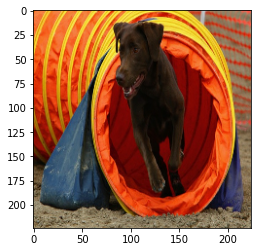

PREDICTED CAPTION: a black dog is emerging from a orange tunnel


In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(a):

    # Select a random image from the validation dataset
    # sample_img = np.random.choice(valid_images)
    #print(sample_img)
    # sample_img = imagee

    # Read the image from the disk
    sample_img = read_image(a)            ##sample_img = read_image(imagee)   ##sample_img=imagee.valid_data(0)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())


 
sample_img = np.random.choice(valid_images)
# print(sample_img)
a=valid_images[28]
print(a)
#photu=""
# Check predictions for a few samples
generate_caption(a)

# generate_caption()
# generate_caption()


In [ ]:
caption_model.val_loss

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(caption_model.caption_model['loss'],'g')
# plt.plot(history.history['accuracy'],'r')
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
A black dog running through a long orange tunnel.
a brown dog coming out of an orange and yellow tunnel
A brown dog running through a large orange tube.
a brown dog runs through a orange tunnel.
The dog is running through a tunnel

In [ ]:
import nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install meteor

     |████████████████████████████████| 6.7MB 8.3MB/s 
  Created wheel for meteor: filename=Meteor-0.1.3-cp37-none-any.whl size=6712005 sha256=6d2965e616e390cf473c723821ea263c4be1fb89056175632aaae953928f2a57
  Stored in directory: /root/.cache/pip/wheels/d6/39/15/7e7329c3e6fb8f8130d6317bb6b7b2c20430c694837de88009
Successfully built meteor


In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5MB 7.1MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
# from meteor import IdentityStage
# from meteor import Language
# from meteor import StemmingStage
from meteor import meteor

# setup matching stages with weights
# stages = [IdentityStage(1.0), StemmingStage(0.6, Language.german)]

hypothesis = "Hi this is abhisht "
reference = "=Hello Abhisht"

score = meteor(hypothesis, reference)

ImportError: ignored

In [ ]:
print (nltk.translate.meteor_score.allign_words(["a black dog running through a long orange tunnel", "a brown dog coming out of an orange and yellow tunnel", 
                                                  'A brown dog running through a large orange tube','a brown dog runs through a orange tunnel',
                                                  'The dog is running through a tunnel'], "a black dog is emerging from a orange tunnel"))

AttributeError: ignored

In [ ]:
A big dog be bite a small dog on the leg
A dog bite the tail of another dog .
A large brown dog sniff a small white dog's behind .
a large brown dog try to catch a small white puppy from behind
A large brown dog be sniff a small white dog .

In [ ]:
import nltk
nltk.download('punkt')
from nltk.util import ngrams

text = "a large brown dog sniffs a smaller white dog s back"

words = nltk.word_tokenize(text)
print(f"words: {words}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
words: ['a', 'large', 'brown', 'dog', 'sniffs', 'a', 'smaller', 'white', 'dog', 's', 'back']


In [ ]:
#Image28
from nltk.translate.bleu_score import sentence_bleu
reference = [['a', 'big', 'dog', 'be', 'bite', 'a', 'small', 'dog', 'on', 'the', 'leg'],
             ['a', 'dog', 'bite', 'the', 'tail', 'of', 'another', 'dog'],
             ['a', 'large', 'brown', 'dog', 'sniff', 'a', 'small', 'white', 'dog', "'s", 'behind'],
             ['a', 'large', 'brown', 'dog', 'try', 'to', 'catch', 'a', 'small', 'white', 'puppy', 'from', 'behind'],
            ['a', 'large', 'brown', 'dog', 'be', 'sniff', 'a', 'small', 'white', 'dog']]
candidate = ['a', 'large', 'brown', 'dog', 'sniff', 'a', 'smaller', 'white', 'dog', 'back']

score1 = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0))
score2 = sentence_bleu(reference, candidate,weights=(0, 1, 0, 0))
score3 = sentence_bleu(reference, candidate,weights=(0, 0, 1, 0))
score4 = sentence_bleu(reference, candidate,weights=(0, 0, 0, 1))
# a=score
print(score1)
print(score2)
print(score3)
print(score4)

0.8
0.6666666666666666
0.5
0.42857142857142855


In [ ]:
pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-oh1wmnl_
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-oh1wmnl_
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-cp37-none-any.whl size=104312216 sha256=f7b51cfaf75f038b24bd9005851dce6b45fe9722a984a5a964baeea0a9ceba8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-g36pjm6c/wheels/43/c5/1e/8c540096ae74b7789563f1ba2a0e195308ee86f445a0cda110
Successfully built pycocoevalcap


In [ ]:
from pycocoevalcap.cider.cider import Cider

In [ ]:
reference = [['a', 'black', 'dog', 'running', 'through', 'a', 'long', 'orange', 'tunnel'],
             ['a', 'brown', 'dog', 'coming', 'out', 'of', 'an', 'orange', 'and', 'yellow', 'tunnel'],
             ['a', 'brown', 'dog', 'running', 'through', 'a', 'large', 'orange', 'tube'],['a', 'brown', 'dog', 'runs', 'through', 'a', 'orange', 'tunnel'],
             ['The', 'dog', 'is', 'running', 'through', 'a', 'tunnel']]
candidate = ['a', 'black', 'dog', 'is', 'emerging', 'from', 'a', 'orange', 'tunnel']
scorer = Cider(reference,candidate)
print(scorer)

In [ ]:
#Image28
from nltk.translate.bleu_score import sentence_bleu
reference = [['a', 'black', 'dog', 'running', 'through', 'a', 'long', 'orange', 'tunnel'],
             ['a', 'brown', 'dog', 'coming', 'out', 'of', 'an', 'orange', 'and', 'yellow', 'tunnel'],
             ['a', 'brown', 'dog', 'running', 'through', 'a', 'large', 'orange', 'tube'],['a', 'brown', 'dog', 'runs', 'through', 'a', 'orange', 'tunnel'],
             ['The', 'dog', 'is', 'running', 'through', 'a', 'tunnel']]
candidate = ['a', 'black', 'dog', 'is', 'emerging', 'from', 'a', 'orange', 'tunnel']

score1 = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0))
score2 = sentence_bleu(reference, candidate,weights=(0, 1, 0, 0))
score3 = sentence_bleu(reference, candidate,weights=(0, 0, 1, 0))
score4 = sentence_bleu(reference, candidate,weights=(0, 0, 0, 1))
# a=score
print(score1)
print(score2)
print(score3)
print(score4)

0.7777777777777778
0.625
0.2857142857142857
1.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
# A child jump from a slide into a pool
# A girl go down a yellow slide into a pool
# A girl be jump into a pool with two slide behind her
# A little girl jump from a yellow ladder into a swim pool
# A young girl in a blue bathe suit jump off of a yellow slide into the water

In [ ]:
pip install nltk

In [ ]:
pip3 install nltk

SyntaxError: ignored

In [ ]:
import nltk
import sys
from nltk.translate.meteor_score import meteor_score

ModuleNotFoundError: ignored

In [ ]:
import nltk
nltk.download('punkt')
from nltk.util import ngrams

text = "A little girl jumps from the yellow ladder into the swimming pool ."

words = nltk.word_tokenize(text)
print(f"words: {words}")

output = list(ngrams(words, 2))
print(f"output: {output}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
words: ['A', 'little', 'girl', 'jumps', 'from', 'the', 'yellow', 'ladder', 'into', 'the', 'swimming', 'pool', '.']
output: [('A', 'little'), ('little', 'girl'), ('girl', 'jumps'), ('jumps', 'from'), ('from', 'the'), ('the', 'yellow'), ('yellow', 'ladder'), ('ladder', 'into'), ('into', 'the'), ('the', 'swimming'), ('swimming', 'pool'), ('pool', '.')]


In [ ]:
#Image #15
from nltk.translate.bleu_score import sentence_bleu
reference = [['a', 'child', 'jump', 'from', 'a', 'slide', 'into', 'a', 'pool'],
             ['a', 'girl', 'go', 'down', 'a', 'yellow', 'slide', 'into', 'a', 'pool'],
             ['a', 'girl', 'be', 'jump', 'into', 'a', 'pool', 'with', 'two', 'slide', 'behind', 'her'],['a', 'little', 'girl', 'jump', 'from', 'a', 'yellow', 'ladder', 'into', 'a', 'swim', 'pool'],['a', 'little', 'girl', 'jumps', 'from', 'the', 'yellow', 'ladder', 'into', 'the', 'swimming', 'pool']            ]
candidate = ['a', 'young', 'girl', 'in', 'a', 'blue', 'bathing', 'suit', 'slides', 'down', 'a', 'yellow', 'slide', 'into', 'a', 'pool']
score = sentence_bleu(reference, candidate)
# a=score
print(score)

0.39653842879131873


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['a', 'black', 'and', 'brown', 'dog', 'run', 'outside'], ['a', 'brown', 'and', 'black', 'dog', 'run', 'on', 'a', 'trail', 'in', 'the', 'wood'],['a', 'doggy', 'run', 'in', 'the', 'dry', 'grass'],
             ['a', 'dog', 'with', 'a', 'red', 'collar', 'run', 'in', 'a', 'forest', 'in', 'the', 'middle', 'of', 'winter']]
candidate = ['a', 'black', 'and', 'brown', 'dog', 'is', 'running', 'through', 'a', 'wooded', 'area']
score = sentence_bleu(reference, candidate)
a=score
print(score)

0.33529572102686117


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['a', 'man', 'on', 'a', 'bicycle', 'in', 'a', 'city'], ['a', 'person', 'be', 'do', 'trick', 'on', 'a', 'bicycle', 'in', 'a', 'city'],['a', 'young', 'man', 'do', 'bicycle', 'trick', 'in', 'an', 'urban', 'area'],['man', 'stand', 'on', 'a', 'bike', 'downtown']]
candidate = ['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'brick', 'wall']
score = sentence_bleu(reference, candidate)
a=score
print(score)

0.4841524713034601


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
# candidate = ['this', 'is', 'test']
# score = sentence_bleu(reference, candidate)
# print(score)

0.8408964152537145


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
